# Self made SVD

In [1]:
import helpers
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from collections import defaultdict
from itertools import chain
import random
import matplotlib.pyplot as plt

train_read = pd.read_csv("./Datasets/ml-100k/train.csv", sep="\t", header=None)
test_read = pd.read_csv("./Datasets/ml-100k/test.csv", sep="\t", header=None)
(
    train_ui,
    test_ui,
    user_code_id,
    user_id_code,
    item_code_id,
    item_id_code,
) = helpers.data_to_csr(train_read, test_read)

In [2]:
# Done similarly to https://github.com/albertauyeung/matrix-factorization-in-python
from tqdm import tqdm


class SVD:
    def __init__(self, train_ui, learning_rate, regularization, nb_factors, iterations):
        self.train_ui = train_ui
        self.uir = list(
            zip(*[train_ui.nonzero()[0], train_ui.nonzero()[1], train_ui.data])
        )

        self.learning_rate = learning_rate
        self.regularization = regularization
        self.iterations = iterations
        self.nb_users, self.nb_items = train_ui.shape
        self.nb_ratings = train_ui.nnz
        self.nb_factors = nb_factors

        self.Pu = np.random.normal(
            loc=0, scale=1.0 / self.nb_factors, size=(self.nb_users, self.nb_factors)
        )
        self.Qi = np.random.normal(
            loc=0, scale=1.0 / self.nb_factors, size=(self.nb_items, self.nb_factors)
        )

    def train(self, test_ui=None):
        if test_ui != None:
            self.test_uir = list(
                zip(*[test_ui.nonzero()[0], test_ui.nonzero()[1], test_ui.data])
            )

        self.learning_process = []
        pbar = tqdm(range(self.iterations))
        for i in pbar:
            pbar.set_description(
                f"Epoch {i} RMSE: {self.learning_process[-1][1] if i>0 else 0}. Training epoch {i+1}..."
            )
            np.random.shuffle(self.uir)
            self.sgd(self.uir)
            if test_ui == None:
                self.learning_process.append([i + 1, self.RMSE_total(self.uir)])
            else:
                self.learning_process.append(
                    [i + 1, self.RMSE_total(self.uir), self.RMSE_total(self.test_uir)]
                )

    def sgd(self, uir):

        for u, i, score in uir:
            # Computer prediction and error
            prediction = self.get_rating(u, i)
            e = score - prediction

            # Update user and item latent feature matrices
            Pu_update = self.learning_rate * (
                e * self.Qi[i] - self.regularization * self.Pu[u]
            )
            Qi_update = self.learning_rate * (
                e * self.Pu[u] - self.regularization * self.Qi[i]
            )

            self.Pu[u] += Pu_update
            self.Qi[i] += Qi_update

    def get_rating(self, u, i):
        prediction = self.Pu[u].dot(self.Qi[i].T)
        return prediction

    def RMSE_total(self, uir):
        RMSE = 0
        for u, i, score in uir:
            prediction = self.get_rating(u, i)
            RMSE += (score - prediction) ** 2
        return np.sqrt(RMSE / len(uir))

    def estimations(self):
        self.estimations = np.dot(self.Pu, self.Qi.T)

    def recommend(self, user_code_id, item_code_id, topK=10):

        top_k = defaultdict(list)
        for nb_user, user_scores in enumerate(self.estimations):

            user_rated = self.train_ui.indices[
                self.train_ui.indptr[nb_user] : self.train_ui.indptr[nb_user + 1]
            ]
            for item, score in enumerate(user_scores):
                if item not in user_rated and not np.isnan(score):
                    top_k[user_code_id[nb_user]].append((item_code_id[item], score))
        result = []
        # Let's choose k best items in the format: (user, item1, score1, item2, score2, ...)
        for uid, item_scores in top_k.items():
            item_scores.sort(key=lambda x: x[1], reverse=True)
            result.append([uid] + list(chain(*item_scores[:topK])))
        return result

    def estimate(self, user_code_id, item_code_id, test_ui):
        result = []
        for user, item in zip(*test_ui.nonzero()):
            result.append(
                [
                    user_code_id[user],
                    item_code_id[item],
                    self.estimations[user, item]
                    if not np.isnan(self.estimations[user, item])
                    else 1,
                ]
            )
        return result

In [3]:
model = SVD(
    train_ui, learning_rate=0.005, regularization=0.02, nb_factors=100, iterations=40
)
model.train(test_ui)

Epoch 39 RMSE: 0.7489999966900885. Training epoch 40...: 100%|██████████| 40/40 [01:02<00:00,  1.57s/it]


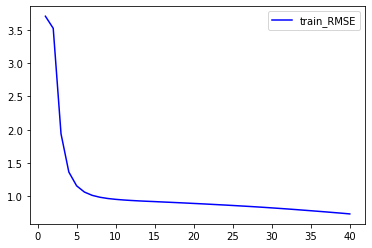

In [4]:
df = pd.DataFrame(model.learning_process).iloc[:, :2]
df.columns = ["epoch", "train_RMSE"]
plt.plot("epoch", "train_RMSE", data=df, color="blue")
plt.legend()

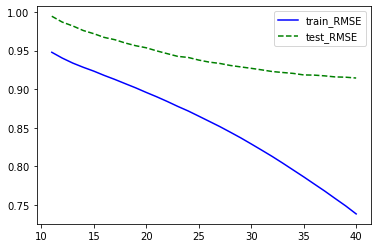

In [5]:
df = pd.DataFrame(
    model.learning_process[10:], columns=["epoch", "train_RMSE", "test_RMSE"]
)
plt.plot("epoch", "train_RMSE", data=df, color="blue")
plt.plot("epoch", "test_RMSE", data=df, color="green", linestyle="dashed")
plt.legend()

#### Saving and evaluating recommendations

In [6]:
model.estimations()

top_n = pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))

top_n.to_csv(
    "Recommendations generated/ml-100k/Self_SVD_reco.csv", index=False, header=False
)

estimations = pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv(
    "Recommendations generated/ml-100k/Self_SVD_estimations.csv",
    index=False,
    header=False,
)

In [7]:
import evaluation_measures as ev

estimations_df = pd.read_csv(
    "Recommendations generated/ml-100k/Self_SVD_estimations.csv", header=None
)
reco = np.loadtxt("Recommendations generated/ml-100k/Self_SVD_reco.csv", delimiter=",")

ev.evaluate(
    test=pd.read_csv("./Datasets/ml-100k/test.csv", sep="\t", header=None),
    estimations_df=estimations_df,
    reco=reco,
    super_reactions=[4, 5],
)

943it [00:00, 8683.10it/s]


RMSE       MAE  precision    recall       F_1      F_05  \
0  0.914393  0.717199   0.101697  0.042334  0.051787  0.068811   

   precision_super  recall_super      NDCG      mAP       MRR      LAUC  \
0         0.092489       0.07236  0.104839  0.04897  0.196117  0.517889   

         HR  Reco in test  Test coverage   Shannon      Gini  
0  0.480382      0.867338       0.147186  3.852545  0.972694

In [8]:
dir_path = "Recommendations generated/ml-100k/"
super_reactions = [4, 5]
test = pd.read_csv("./Datasets/ml-100k/test.csv", sep="\t", header=None)

ev.evaluate_all(test, dir_path, super_reactions)

943it [00:00, 8505.85it/s]
943it [00:00, 9544.72it/s]
943it [00:00, 9154.80it/s]
943it [00:00, 8282.66it/s]
943it [00:00, 8432.23it/s]
943it [00:00, 9601.30it/s]
943it [00:00, 9158.89it/s]
943it [00:00, 12283.59it/s]
943it [00:00, 9500.43it/s]
943it [00:00, 10085.91it/s]
943it [00:00, 10260.90it/s]
943it [00:00, 9691.20it/s]


Model      RMSE       MAE  precision    recall       F_1  \
0          Self_TopPop  2.508258  2.217909   0.188865  0.116919  0.118732   
0            Ready_SVD  0.950347  0.749312   0.100636  0.050514  0.055794   
0             Self_SVD  0.914393  0.717199   0.101697  0.042334  0.051787   
0       Ready_Baseline  0.949459  0.752487   0.091410  0.037652  0.046030   
0      Ready_SVDBiased  0.939472  0.739816   0.085896  0.036073  0.043528   
0         Ready_Random  1.521845  1.225949   0.047190  0.020753  0.024810   
0          Ready_I-KNN  1.030386  0.813067   0.026087  0.006908  0.010593   
0  Ready_I-KNNBaseline  0.935327  0.737424   0.002545  0.000755  0.001105   
0          Ready_U-KNN  1.023495  0.807913   0.000742  0.000205  0.000305   
0        Self_TopRated  1.030712  0.820904   0.000954  0.000188  0.000298   
0      Self_BaselineUI  0.967585  0.762740   0.000954  0.000170  0.000278   
0            Self_IKNN  1.018363  0.808793   0.000318  0.000108  0.000140   

       F_05  precision_super  recall_super      NDCG       mAP       MRR  \
0  0.141584         0.130472      0.137473  0.214651  0.111707  0.400939   
0  0.070753         0.091202      0.082734  0.114054  0.053200  0.248803   
0  0.068811         0.092489      0.072360  0.104839  0.048970  0.196117   
0  0.061286         0.079614      0.056463  0.095957  0.043178  0.198193   
0  0.057643         0.077039      0.057463  0.097753  0.045546  0.219839   
0  0.032269         0.029506      0.023707  0.050075  0.018728  0.121957   
0  0.016046         0.021137      0.009522  0.024214  0.008958  0.048068   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.000449         0.000536      0.000198  0.000845  0.000274  0.002744   
0  0.000481         0.000644      0.000223  0.001043  0.000335  0.003348   
0  0.000463         0.000644      0.000189  0.000752  0.000168  0.001677   
0  0.000189         0.000000      0.000000  0.000214  0.000037  0.000368   

       LAUC        HR  Reco in test  Test coverage   Shannon      Gini  
0  0.555546  0.765642      1.000000       0.038961  3.159079  0.987317  
0  0.521983  0.517497      0.992153       0.210678  4.418683  0.952848  
0  0.517889  0.480382      0.867338       0.147186  3.852545  0.972694  
0  0.515501  0.437964      1.000000       0.033911  2.836513  0.991139  
0  0.514709  0.431601      0.997455       0.168831  4.217578  0.962577  
0  0.506893  0.329799      0.986532       0.184704  5.099706  0.907217  
0  0.499885  0.154825      0.402333       0.434343  5.133650  0.877999  
0  0.496724  0.021209      0.482821       0.059885  2.232578  0.994487  
0  0.496441  0.007423      0.602121       0.010823  2.089186  0.995706  
0  0.496433  0.009544      0.699046       0.005051  1.945910  0.995669  
0  0.496424  0.009544      0.600530       0.005051  1.803126  0.996380  
0  0.496391  0.003181      0.392153       0.115440  4.174741  0.965327

### Embeddings

In [9]:
item = random.choice(list(set(train_ui.indices)))

embeddings_norm = (
    model.Qi / np.linalg.norm(model.Qi, axis=1)[:, None]
)  # we do not mean-center here
# omitting normalization also makes sense, but items with a greater magnitude will be recommended more often

similarity_scores = np.dot(embeddings_norm, embeddings_norm[item].T)
top_similar_items = pd.DataFrame(
    enumerate(similarity_scores), columns=["code", "score"]
).sort_values(by=["score"], ascending=[False])[:10]

top_similar_items["item_id"] = top_similar_items["code"].apply(
    lambda x: item_code_id[x]
)

items = pd.read_csv("./Datasets/ml-100k/movies.csv")

result = pd.merge(top_similar_items, items, left_on="item_id", right_on="id")

result

code     score  item_id    id                                 title  \
0   321  1.000000      322   322                 Murder at 1600 (1997)   
1   983  0.902748      984   984              Shadow Conspiracy (1997)   
2   985  0.894696      986   986                     Turbulence (1997)   
3   778  0.890524      779   779                      Drop Zone (1994)   
4   686  0.889220      687   687                  McHale's Navy (1997)   
5   331  0.887596      332   332                 Kiss the Girls (1997)   
6   987  0.886547      988   988  Beautician and the Beast, The (1997)   
7  1039  0.882845     1040  1040                  Two if by Sea (1996)   
8  1022  0.882782     1023  1023                   Fathers' Day (1997)   
9   929  0.877662      930   930                 Chain Reaction (1996)   

                        genres  
0            Mystery, Thriller  
1                     Thriller  
2                     Thriller  
3                       Action  
4                  Comedy, War  
5       Crime, Drama, Thriller  
6              Comedy, Romance  
7              Comedy, Romance  
8                       Comedy  
9  Action, Adventure, Thriller

# project task 5:  implement SVD on top baseline (as it is in Surprise library)

In [10]:
# making changes to our implementation by considering additional parameters in the gradient descent procedure
# seems to be the fastest option
# please save the output in 'Recommendations generated/ml-100k/Self_SVDBaseline_reco.csv' and
# 'Recommendations generated/ml-100k/Self_SVDBaseline_estimations.csv'

# Ready-made SVD - Surprise implementation

### SVD

In [11]:
import helpers
import surprise as sp

algo = sp.SVD(biased=False)  # to use unbiased version

helpers.ready_made(
    algo,
    reco_path="Recommendations generated/ml-100k/Ready_SVD_reco.csv",
    estimations_path="Recommendations generated/ml-100k/Ready_SVD_estimations.csv",
)

Generating predictions...
Generating top N recommendations...
Generating predictions...


### SVD biased - on top baseline

In [12]:
algo = sp.SVD()  # default is biased=True

helpers.ready_made(
    algo,
    reco_path="Recommendations generated/ml-100k/Ready_SVDBiased_reco.csv",
    estimations_path="Recommendations generated/ml-100k/Ready_SVDBiased_estimations.csv",
)

Generating predictions...
Generating top N recommendations...
Generating predictions...


In [13]:
dir_path = "Recommendations generated/ml-100k/"
super_reactions = [4, 5]
test = pd.read_csv("./Datasets/ml-100k/test.csv", sep="\t", header=None)

ev.evaluate_all(test, dir_path, super_reactions)

943it [00:00, 11456.53it/s]
943it [00:00, 11932.50it/s]
943it [00:00, 10853.07it/s]
943it [00:00, 9426.44it/s]
943it [00:00, 8757.09it/s]
943it [00:00, 9999.67it/s]
943it [00:00, 11323.49it/s]
943it [00:00, 9764.72it/s]
943it [00:00, 9692.41it/s]
943it [00:00, 9052.77it/s]
943it [00:00, 8645.18it/s]
943it [00:00, 10594.54it/s]


Model      RMSE       MAE  precision    recall       F_1  \
0          Self_TopPop  2.508258  2.217909   0.188865  0.116919  0.118732   
0            Ready_SVD  0.951652  0.750975   0.096394  0.047252  0.052870   
0             Self_SVD  0.914393  0.717199   0.101697  0.042334  0.051787   
0       Ready_Baseline  0.949459  0.752487   0.091410  0.037652  0.046030   
0      Ready_SVDBiased  0.940413  0.739571   0.086002  0.035478  0.043196   
0         Ready_Random  1.521845  1.225949   0.047190  0.020753  0.024810   
0          Ready_I-KNN  1.030386  0.813067   0.026087  0.006908  0.010593   
0  Ready_I-KNNBaseline  0.935327  0.737424   0.002545  0.000755  0.001105   
0          Ready_U-KNN  1.023495  0.807913   0.000742  0.000205  0.000305   
0        Self_TopRated  1.030712  0.820904   0.000954  0.000188  0.000298   
0      Self_BaselineUI  0.967585  0.762740   0.000954  0.000170  0.000278   
0            Self_IKNN  1.018363  0.808793   0.000318  0.000108  0.000140   

       F_05  precision_super  recall_super      NDCG       mAP       MRR  \
0  0.141584         0.130472      0.137473  0.214651  0.111707  0.400939   
0  0.067257         0.085515      0.074754  0.109578  0.051562  0.235567   
0  0.068811         0.092489      0.072360  0.104839  0.048970  0.196117   
0  0.061286         0.079614      0.056463  0.095957  0.043178  0.198193   
0  0.057507         0.075751      0.053460  0.094897  0.043361  0.209124   
0  0.032269         0.029506      0.023707  0.050075  0.018728  0.121957   
0  0.016046         0.021137      0.009522  0.024214  0.008958  0.048068   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.000449         0.000536      0.000198  0.000845  0.000274  0.002744   
0  0.000481         0.000644      0.000223  0.001043  0.000335  0.003348   
0  0.000463         0.000644      0.000189  0.000752  0.000168  0.001677   
0  0.000189         0.000000      0.000000  0.000214  0.000037  0.000368   

       LAUC        HR  Reco in test  Test coverage   Shannon      Gini  
0  0.555546  0.765642      1.000000       0.038961  3.159079  0.987317  
0  0.520341  0.496288      0.995546       0.208514  4.455755  0.951624  
0  0.517889  0.480382      0.867338       0.147186  3.852545  0.972694  
0  0.515501  0.437964      1.000000       0.033911  2.836513  0.991139  
0  0.514405  0.428420      0.997349       0.177489  4.212509  0.962656  
0  0.506893  0.329799      0.986532       0.184704  5.099706  0.907217  
0  0.499885  0.154825      0.402333       0.434343  5.133650  0.877999  
0  0.496724  0.021209      0.482821       0.059885  2.232578  0.994487  
0  0.496441  0.007423      0.602121       0.010823  2.089186  0.995706  
0  0.496433  0.009544      0.699046       0.005051  1.945910  0.995669  
0  0.496424  0.009544      0.600530       0.005051  1.803126  0.996380  
0  0.496391  0.003181      0.392153       0.115440  4.174741  0.965327